C:\Users\aparn\AppData\Local\Temp\ipykernel_26428\8097620.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)
C:\Users\aparn\AppData\Local\Temp\ipykernel_26428\8097620.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Scratch model metrics:
Accuracy=0.8045, Precision=0.7931, Recall=0.6667, F1=0.7244, ROC-AUC=0.8437

Scratch coefficients:
Intercept: -0.662123
Pclass: -0.951207
Sex: -1.287862
Age: -0.516057
Fare: 0.092054
SibSp: -0.268246
Parch: -0.069699
Embarked_Q: 0.082914
Embarked_S: -0.173036


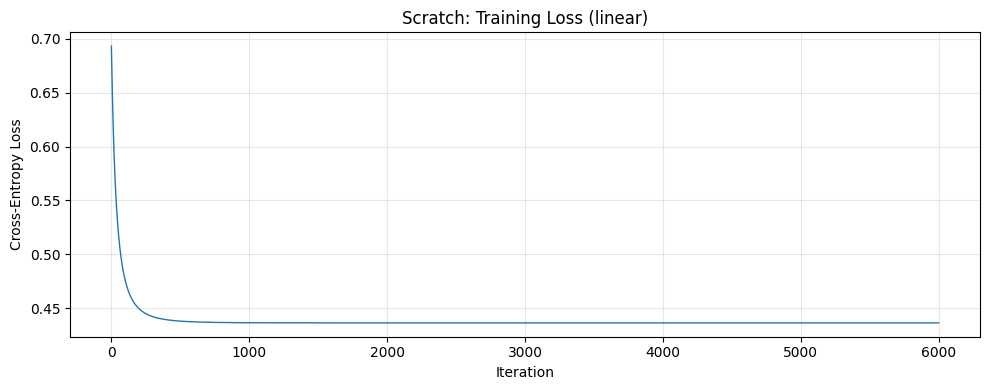

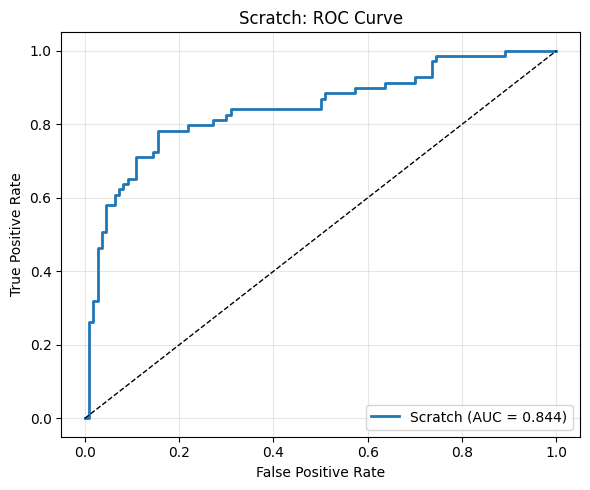

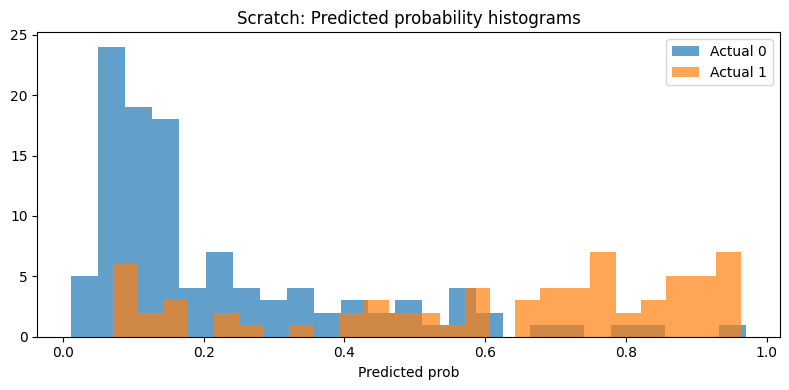

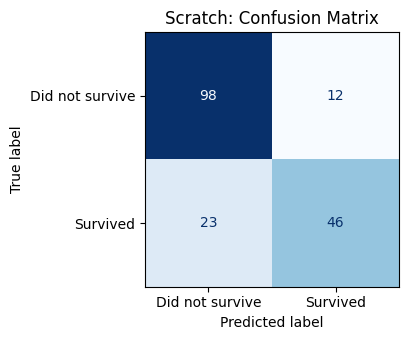


Feature names (order): ['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S']
Final loss (last recorded): 0.436269 at iter 6000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay)

CSV_PATH = r"C:\Users\aparn\Downloads\titanic\train.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
LR = 0.05
ITERS = 6000
LAMBDA = 0.0
CLIP_Z = 30.0
RECORD_EVERY = 1

df = pd.read_csv(CSV_PATH)
features = ["Pclass", "Sex", "Age", "Fare", "SibSp", "Parch", "Embarked"]
df = df[features + ["Survived"]].copy()
df["Age"].fillna(df["Age"].median(), inplace=True)
df["Fare"].fillna(df["Fare"].median(), inplace=True)
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
df["Sex"] = df["Sex"].map({"male":1,"female":0})
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

X_df = df.drop(columns=["Survived"])
feature_names = X_df.columns.tolist()
X = X_df.values.astype(float)
y = df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)

def sigmoid(z):
    z = np.clip(z, -CLIP_Z, CLIP_Z)
    return 1.0 / (1.0 + np.exp(-z))

def compute_loss_ce(y_true, p):
    eps = 1e-12
    return -(1.0 / y_true.shape[0]) * np.sum(y_true * np.log(np.clip(p, eps, 1-eps)) + (1-y_true) * np.log(np.clip(1-p, eps, 1-eps)))

def gd_logistic_l2(Xd, yv, lr=LR, iters=ITERS, lambda_=LAMBDA, record_every=RECORD_EVERY):
    m, d = Xd.shape
    X1 = np.hstack([np.ones((m,1)), Xd])
    theta = np.zeros((d+1,1))
    yv = yv.reshape(-1,1)
    iters_record, losses = [], []
    for it in range(1, iters+1):
        z = X1 @ theta
        p = sigmoid(z)
        grad = (X1.T @ (p - yv)) / m
        reg = np.vstack([[[0.0]], lambda_ * theta[1:]])
        theta -= lr * (grad + reg)
        if it % record_every == 0:
            loss = compute_loss_ce(yv.ravel(), p.ravel())
            iters_record.append(it); losses.append(float(loss))
    return theta.ravel(), np.array(iters_record), np.array(losses)

theta_scratch, iters_hist, loss_hist = gd_logistic_l2(Xtr, y_train, lr=LR, iters=ITERS, lambda_=LAMBDA, record_every=RECORD_EVERY)

Xte1 = np.hstack([np.ones((Xte.shape[0],1)), Xte])
proba_scratch = sigmoid(Xte1 @ theta_scratch.reshape(-1,1)).ravel()
pred_scratch = (proba_scratch >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_scratch)
prec = precision_score(y_test, pred_scratch, zero_division=0)
rec = recall_score(y_test, pred_scratch, zero_division=0)
f1 = f1_score(y_test, pred_scratch, zero_division=0)
auc_score = roc_auc_score(y_test, proba_scratch)

print("Scratch model metrics:")
print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={auc_score:.4f}")

scratch_intercept = float(theta_scratch[0])
scratch_coefs = theta_scratch[1:]
print("\nScratch coefficients:")
print(f"Intercept: {scratch_intercept:.6f}")
for fname, val in zip(feature_names, scratch_coefs):
    print(f"{fname}: {val:.6f}")

plt.figure(figsize=(10,4))
plt.plot(iters_hist, loss_hist, linewidth=1)
plt.xlabel("Iteration"); plt.ylabel("Cross-Entropy Loss")
plt.title("Scratch: Training Loss (linear)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("scratch_titanic_loss_linear.png", dpi=300, bbox_inches="tight")
plt.show()

fpr, tpr, _ = roc_curve(y_test, proba_scratch)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Scratch (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Scratch: ROC Curve")
plt.legend(loc="lower right"); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("scratch_titanic_roc.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(proba_scratch[y_test==0], bins=25, alpha=0.7, label="Actual 0")
plt.hist(proba_scratch[y_test==1], bins=25, alpha=0.7, label="Actual 1")
plt.title("Scratch: Predicted probability histograms"); plt.xlabel("Predicted prob")
plt.legend(); plt.tight_layout()
plt.savefig("scratch_titanic_prob_hist.png", dpi=300, bbox_inches="tight")
plt.show()

cm = confusion_matrix(y_test, pred_scratch)
disp = ConfusionMatrixDisplay(cm, display_labels=["Did not survive","Survived"])
fig, ax = plt.subplots(figsize=(4.5,3.5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Scratch: Confusion Matrix"); plt.tight_layout()
plt.savefig("scratch_titanic_confusion.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nFeature names (order):", feature_names)
print(f"Final loss (last recorded): {loss_hist[-1]:.6f} at iter {iters_hist[-1]}")
